# Blending Predictions through Simple Averaging

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt;

%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, cohen_kappa_score, brier_score_loss
from sklearn.linear_model import LogisticRegression

from scipy.stats.mstats import gmean, hmean
from sklearn.preprocessing import minmax_scale

In [2]:
def read_predictions(prediction_dir, mode='valid', valid_columns=None, stacking_mode='flat'):
    valid_labels = pd.read_csv(os.path.join(prediction_dir, 'valid_split.csv'))
    sample_submission = pd.read_csv(os.path.join(prediction_dir, 'sample_submission.csv'))
    
    predictions = []
    filenames = []
    
    for filepath in sorted(glob.glob('{}/{}/*'.format(prediction_dir, mode))):
        prediction_single = pd.read_csv(filepath)
        prediction_single.drop('id', axis=1, inplace=True)
        predictions.append(prediction_single)
        filenames.append(filepath.split("\\")[-1])

    return predictions, sample_submission, filenames

In [3]:
LABEL_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

SINGLE_DIR = 'single_model_predictions'
SAMPLE_SUBMISSION_PATH = 'single_model_predictions/sample_submission.csv'

In [4]:
valid_split  = pd.read_csv('single_model_predictions/valid_split.csv').drop('comment_text', axis=1)
valid_actual = pd.read_csv('single_model_predictions/valid_split.csv').drop('comment_text', axis=1)

valid_predictions, _, valid_names = read_predictions(SINGLE_DIR, mode='valid')

In [5]:
pred_scores = pd.DataFrame(columns=['name', 'score', 'stddev'])

for prediction, name in zip(valid_predictions, valid_names):
    scores = []

    for label in LABEL_COLUMNS:
        score = roc_auc_score(valid_actual[label], prediction[label])
        #print(label + ' score = ' + str(score))
        scores.append(score)
    
    pred_scores = pred_scores.append({'name':name, 'score':np.mean(scores), 'stddev':np.std(scores)}, ignore_index=True)

,name,score,stddev
0,18_02_16_BagOfWords_TFIDF_LogisticRegression_V...,0.985529,0.004436
1,18_02_18_pooledgru_valid.csv,0.984768,0.003736
2,18_03_11_DPCNN_SCNN_GRU_Valid.csv,0.990140,0.003719
3,18_03_11_FastTextGRU_Valid.csv,0.990036,0.003918
4,18_03_11_LSTM_Valid.csv,0.990253,0.004114
5,18_03_17_Pavel_Valid.csv,0.989998,0.003000
6,Wordbatch_Merged_VALID.csv,0.987584,0.004614
7,char_vdcnn_valid.csv,0.973076,0.012755
8,lvl0_lgbm_clean_VALID.csv,0.983589,0.006970


In [6]:
pred_scores.sort_values('score', ascending=False)

,name,score,stddev
4,18_03_11_LSTM_Valid.csv,0.990253,0.004114
2,18_03_11_DPCNN_SCNN_GRU_Valid.csv,0.990140,0.003719
3,18_03_11_FastTextGRU_Valid.csv,0.990036,0.003918
5,18_03_17_Pavel_Valid.csv,0.989998,0.003000
6,Wordbatch_Merged_VALID.csv,0.987584,0.004614
0,18_02_16_BagOfWords_TFIDF_LogisticRegression_V...,0.985529,0.004436
1,18_02_18_pooledgru_valid.csv,0.984768,0.003736
8,lvl0_lgbm_clean_VALID.csv,0.983589,0.006970
7,char_vdcnn_valid.csv,0.973076,0.012755


# Visualize Probability Distributions

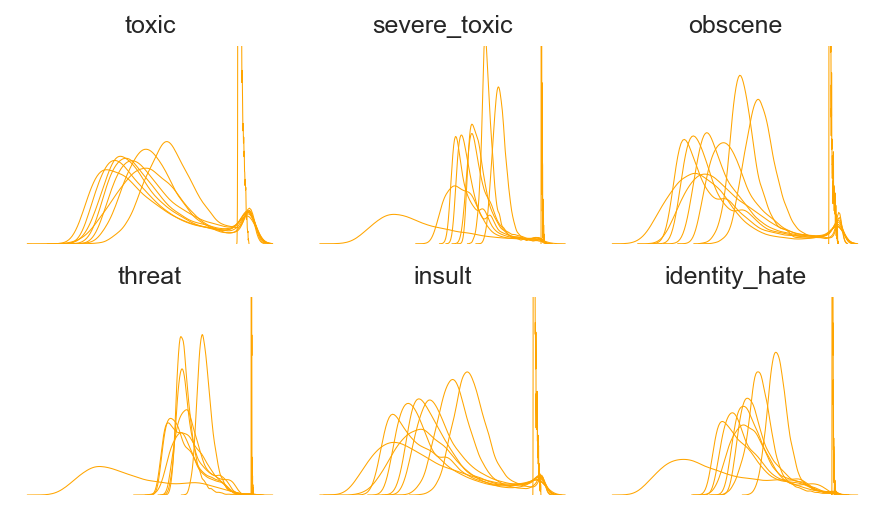

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    probabilities = [prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]
    for k in range(len(probabilities)):
        sns.kdeplot(np.log(probabilities[k]), ax=ax, shade=False, color="orange", linewidth=0.5);
    ax.set_title(LABEL_COLUMNS[i]);ax.grid(False);ax.set_facecolor('white');ax.set_xticklabels([]);ax.set_yticklabels([]);
    ax.set_ybound(0, 0.5)
    
fig.tight_layout()

# Recall (True Positive Rate) vs Threshold (aka Cumulative Response Curve)

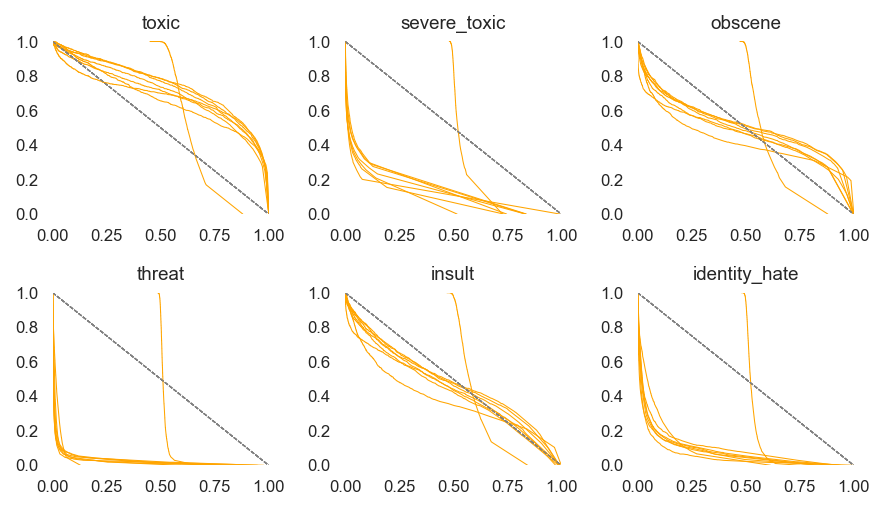

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    probabilities = [prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]
    
    for k in range(len(probabilities)):
        fpr, tpr, thresholds = roc_curve(valid_actual[LABEL_COLUMNS[0]], probabilities[k])

        recall = tpr
        
        ax.plot(thresholds, recall, "orange", lw=0.5)
        ax.plot([0, 1], [1,0], "grey", lw=0.5, ls='--')
    
    ax.set_title(LABEL_COLUMNS[i], size=9);ax.set_ybound([0, 1]);ax.set_xbound([0, 1]);ax.grid(False);ax.set_facecolor('white');
    ax.tick_params(labelsize=8);#ax.set_xticks([]);ax.set_yticks([]);
    
fig.tight_layout()

# Lift Curve

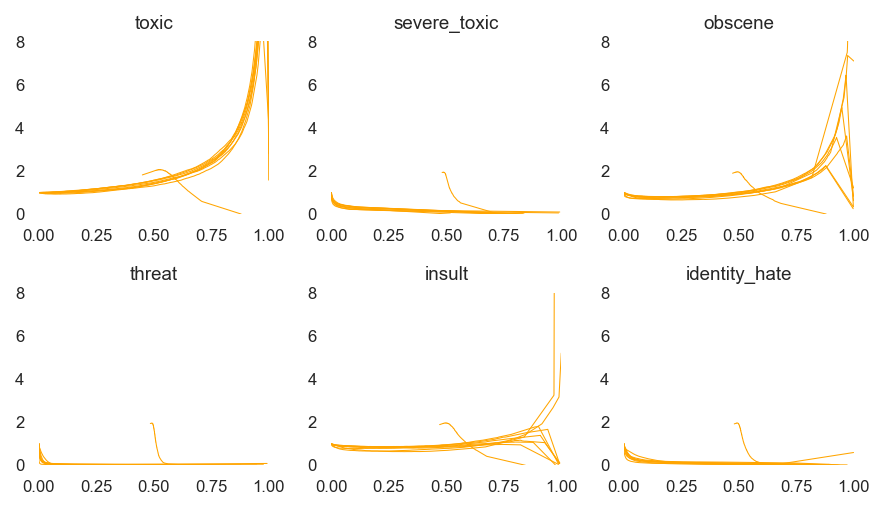

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    probabilities = [prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]
    
    for k in range(len(probabilities)):
        fpr, tpr, thresholds = roc_curve(valid_actual[LABEL_COLUMNS[0]], probabilities[k])

        recall = tpr
        
        ax.plot(thresholds, recall/(1-thresholds), "orange", lw=0.5)
    
    ax.set_title(LABEL_COLUMNS[i], size=9);ax.set_ybound([0, 8]);ax.set_xbound([0, 1]);ax.grid(False);ax.set_facecolor('white');
    ax.tick_params(labelsize=8);#ax.set_xticks([]);ax.set_yticks([]);
    
fig.tight_layout()

# Precision vs Threshold

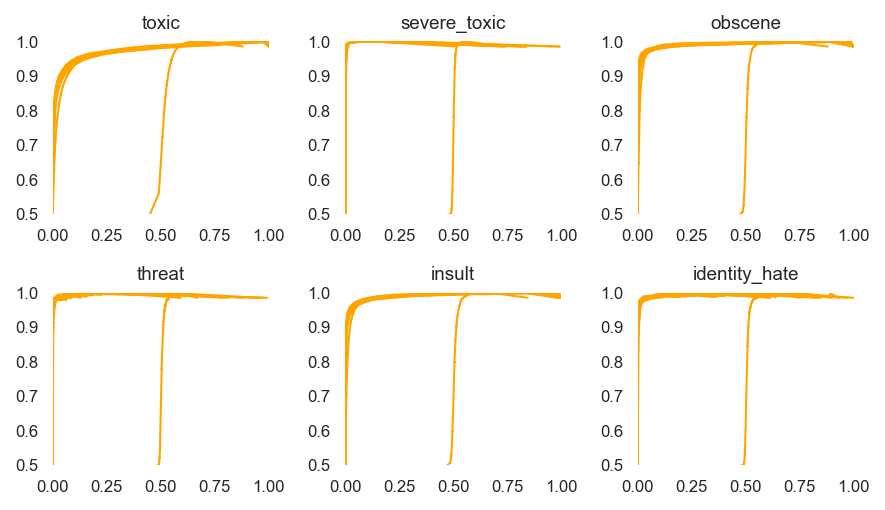

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    probabilities = [prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]
    
    for k in range(len(probabilities)):
        fpr, tpr, thresholds = roc_curve(valid_actual[LABEL_COLUMNS[0]], probabilities[k])
        precision = tpr / (fpr + tpr + 1e-5)

        ax.plot(thresholds, precision, "orange", lw=1)
    
    ax.set_title(LABEL_COLUMNS[i], size=9);ax.set_ybound([0.5, 1]);ax.set_xbound([0, 1]);ax.grid(False);ax.set_facecolor('white');
    ax.tick_params(labelsize=8);#ax.set_xticks([]);ax.set_yticks([]);
    
fig.tight_layout()

# Check F1 Scores vs. Probability Threshold

F1 = (2 x Precision x Recall) / (Precision + Recall)

Precision = True Positives / Predicted Positive

Recall = True Positive / Actually Positive

Between models, the F1 score for the same threshold can vary widely. Between labels, there is even more variance.

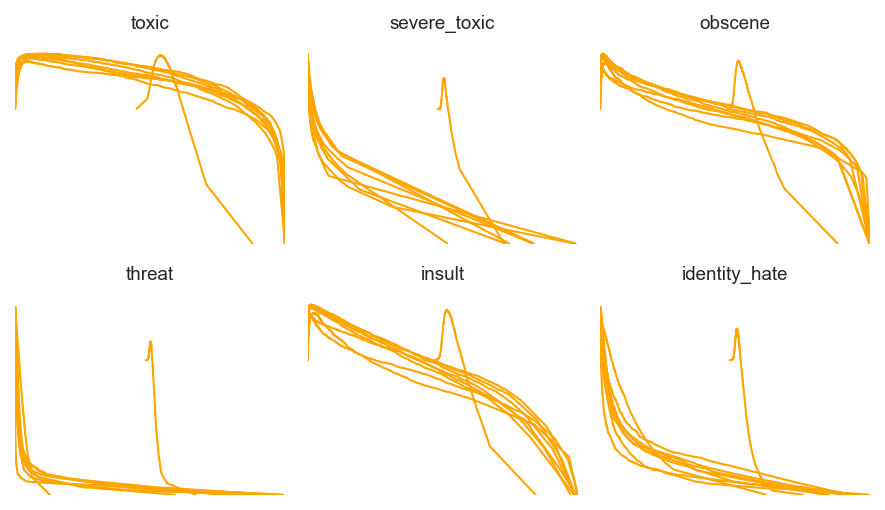

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    probabilities = [prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]
    
    for k in range(len(probabilities)):
        fpr, tpr, thresholds = roc_curve(valid_actual[LABEL_COLUMNS[0]], probabilities[k])

        recall = tpr
        precision = tpr / (fpr + tpr + 1e-5)
        f1_scores = 2 * precision * recall / (precision + recall + 1e-5)

        ax.plot(thresholds, f1_scores, "orange", lw=1)
    
    ax.set_title(LABEL_COLUMNS[i], size=9);ax.set_ybound([0, 1]);ax.set_xbound([0, 1]);ax.grid(False);ax.set_facecolor('white');
    ax.tick_params(labelsize=8);ax.set_xticks([]);ax.set_yticks([]);
    
fig.tight_layout()

# ROC-AUC Curves

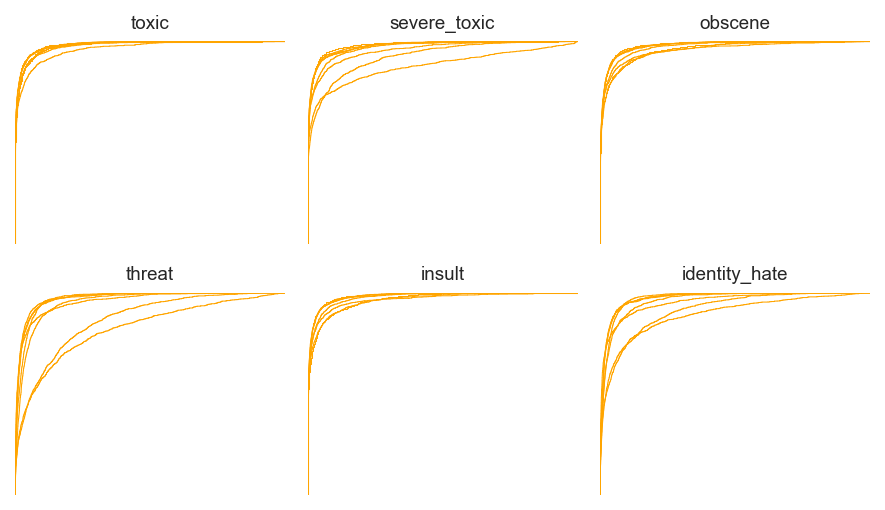

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    probabilities = [prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]
    
    for k in range(len(probabilities)):
        fpr, tpr, thresholds = roc_curve(valid_actual[LABEL_COLUMNS[0]], probabilities[k])

        recall = tpr
        precision = tpr / (fpr + tpr + 1e-5)
        f1_scores = 2 * precision * recall / (precision + recall + 1e-5)

        ax.plot(fpr, tpr, "orange", lw=0.5)
    
    ax.set_title(LABEL_COLUMNS[i], size=9);ax.set_ybound([0, 1]);ax.set_xbound([0, 1]);ax.grid(False);ax.set_facecolor('white');
    ax.tick_params(labelsize=8);ax.set_xticks([]);ax.set_yticks([]);
    
fig.tight_layout()

# Log-Loss

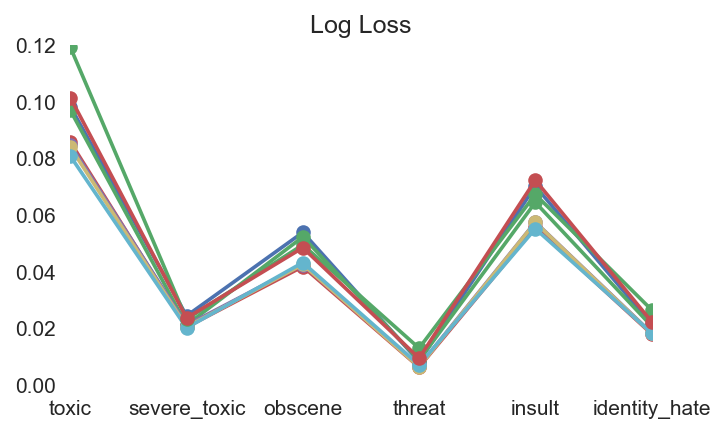

In [12]:
fig = plt.figure(figsize=(5,3), dpi=150)

ax = fig.add_subplot(111)

for k in range(len(valid_predictions)):
    scores = []

    for label in LABEL_COLUMNS:
        scores.append(log_loss(valid_actual[label], [prediction[label].values for prediction in valid_predictions][k]))

    ax.plot(scores, marker='o')
    
ax.grid(False);ax.set_facecolor('white');ax.set_xbound([0, 5]);ax.set_xticks([]);ax.set_ybound([0, 0.12]);
ax.set_title('Log Loss');plt.xticks(range(6), LABEL_COLUMNS);

# Visualize Correlations

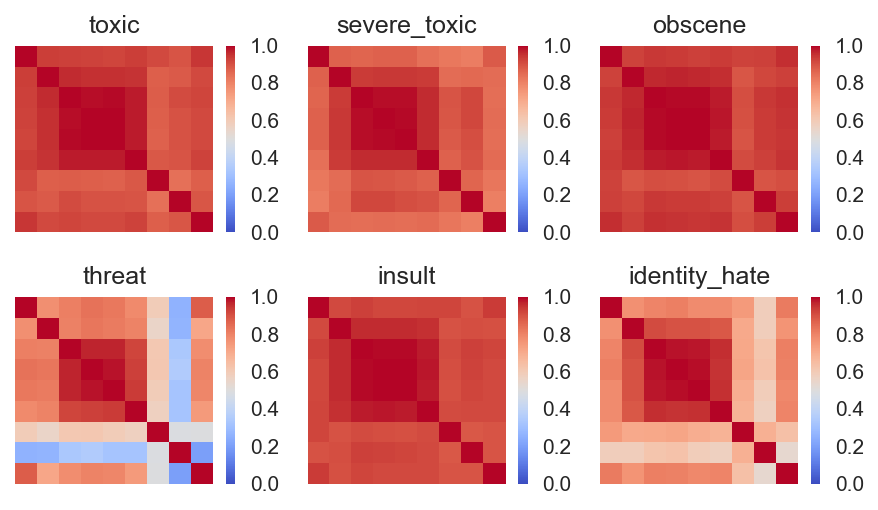

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 3.5), dpi=150)

for i, ax in enumerate(fig.axes):
    df = pd.DataFrame(np.transpose([prediction[LABEL_COLUMNS[i]].values for prediction in valid_predictions]))    
    sns.heatmap(df.corr(), ax=ax, cmap='coolwarm', vmin=0, vmax=1, xticklabels=False, yticklabels=False)
    ax.set_title(LABEL_COLUMNS[i])
    
fig.tight_layout()

# Blend Validation Predictions

### Arithmetic Mean

In [27]:
for label in LABEL_COLUMNS:
    valid_split[label] = np.mean([prediction[label].values for prediction in valid_predictions], axis=0)

scores = []

for label in LABEL_COLUMNS:
    score = roc_auc_score(valid_actual[label], valid_split[label])
    print(label + ' score = ' + str(score))
    scores.append(score)

print('\nscore average = {}\nscore std = {}'.format(np.mean(scores),np.std(scores)))

toxic score = 0.9876825202150729
severe_toxic score = 0.9921866159657209
obscene score = 0.9948907720347074
threat score = 0.995863197656153
insult score = 0.988994983301979
identity_hate score = 0.9913379558507489

score average = 0.9918260075040637
score std = 0.0029224163454853393


### Geometric Mean

In [15]:
for label in LABEL_COLUMNS:
    valid_split[label] = gmean([prediction[label].values for prediction in valid_predictions], axis=0)

scores = []

for label in LABEL_COLUMNS:
    score = roc_auc_score(valid_actual[label], valid_split[label])
    print(label + ' score = ' + str(score))
    scores.append(score)

print('\nscore average = {}\nscore std = {}'.format(np.mean(scores),np.std(scores)))

toxic score = 0.9870441420973765
severe_toxic score = 0.9915993214058756
obscene score = 0.9942203837425492
threat score = 0.9959537952348596
insult score = 0.9885665040614837
identity_hate score = 0.9899657969598218

score average = 0.9912249905836611
score std = 0.003098567152899193


### Harmonic Mean

In [14]:
for label in LABEL_COLUMNS:
    valid_split[label] = hmean([(prediction[label].values + (1e-9)) for prediction in valid_predictions], axis=0)

scores = []

for label in LABEL_COLUMNS:
    score = roc_auc_score(valid_actual[label], valid_split[label])
    print(label + ' score = ' + str(score))
    scores.append(score)

print('\nscore average = {}\nscore std = {}'.format(np.mean(scores),np.std(scores)))

toxic score = 0.9837112640458174
severe_toxic score = 0.9900474009096396
obscene score = 0.9907457046937026
threat score = 0.99432303881814
insult score = 0.9862924924530777
identity_hate score = 0.9860962157193197

score average = 0.9885360194399495
score std = 0.003533668921964729


### Arithmetic Mean + MinMaxScale

In [16]:
for label in LABEL_COLUMNS:
    valid_split[label] = np.mean([minmax_scale(prediction[label].values) for prediction in valid_predictions], axis=0)

scores = []

for label in LABEL_COLUMNS:
    score = roc_auc_score(valid_actual[label], valid_split[label])
    print(label + ' score = ' + str(score))
    scores.append(score)

print('\nscore average = {}\nscore std = {}'.format(np.mean(scores),np.std(scores)))

toxic score = 0.9877792910119882
severe_toxic score = 0.9921530562765869
obscene score = 0.9949273556449785
threat score = 0.9932051815970016
insult score = 0.9890000875005468
identity_hate score = 0.9912918894074094

score average = 0.9913928102397519
score std = 0.002420347892529709


### Power Average

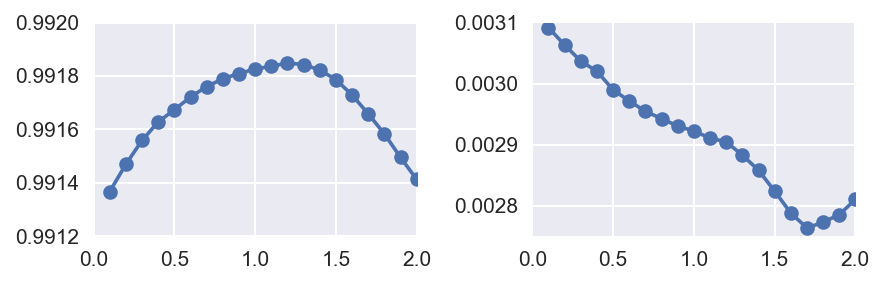

In [19]:
def power_average(columns, power):
    avg = np.zeros(len(columns[0]))
    
    for i in range(len(columns)):
        avg = avg + (columns[i]**power);
        
    avg = avg / len(columns);
    
    return avg;

x = np.arange(0.1, 2.1, 0.1);
y = []
ystd = []

for power in x:
    
    for label in LABEL_COLUMNS:
        valid_split[label] = power_average([prediction[label].values for prediction in valid_predictions], power)

    scores = []

    for label in LABEL_COLUMNS:
        score = roc_auc_score(valid_actual[label], valid_split[label])
        scores.append(score)
        
    y.append(np.mean(scores))
    ystd.append(np.std(scores))
    
fig = plt.figure(figsize=(6, 2), dpi=150)

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(x, y, marker='o')
ax2.plot(x, ystd, marker='o')
    
ax.grid(True);#ax.set_facecolor('white');
ax2.grid(True);#ax2.set_facecolor('white');
ax.set_xbound([0, 2]);ax2.set_xbound([0, 2]);
#ax.set_xticks([]);
ax.set_ybound([0.9912, 0.9920]);ax2.set_ybound([0.00275, 0.0031]);
#ax.set_title('Log Loss');plt.xticks(range(6), LABEL_COLUMNS);

fig.tight_layout()

# Blend Test Predictions

In [28]:
predictions, sample_submission, _ = read_predictions(SINGLE_DIR, mode='test')

In [31]:
for label in LABEL_COLUMNS:
    sample_submission[label] = np.mean([prediction[label].values for prediction in predictions], axis=0)

In [32]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.967846,0.414478,0.947727,0.148255,0.914529,0.398455
1,0000247867823ef7,0.061126,0.056356,0.055764,0.055733,0.057149,0.056488
2,00013b17ad220c46,0.060834,0.055740,0.058398,0.055876,0.055948,0.056120
3,00017563c3f7919a,0.054222,0.055267,0.054690,0.055662,0.054928,0.055195
4,00017695ad8997eb,0.062175,0.055526,0.056584,0.055597,0.056858,0.056210


In [33]:
ENSEMBLE_SUBMISSION_PATH = 'submissions/18_03_19_Updated_Simple_Average.csv'

sample_submission.to_csv(ENSEMBLE_SUBMISSION_PATH, index=None)